In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
'''plt.rcParams.update({
    "text.usetex": True})'''

'plt.rcParams.update({\n    "text.usetex": True})'

In [3]:
G = u.gravitational_constant
q0 = 1e6
beta = 1
M = q0 * u.Msun
rT = q0**(1 / 3) * u.Rsun
deltaE = (G * M / rT**2 * u.Rsun).in_cgs()

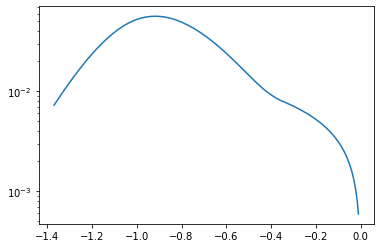

In [9]:
dmdt_t0 = np.loadtxt('1.000.dat')
t0 = dmdt_t0[:, 0]
dmdt0 = dmdt_t0[:, 1]
dedt0 = (2 / 3 * (G**2 * M**2 * np.pi**2 / 2)**(1 / 3) *
        (t0 * u.day)**(-5 / 3)).in_cgs()
dmde0 = (dmdt0 * (u.Msun / u.yr) / dedt0).in_cgs()
E = -((G**2 * M**2 * np.pi**2 / 2)**(1 / 3) * (t0 * u.day)**(-2 / 3)).in_cgs()
E_dE = E / deltaE
dmde_dE = dmde0 * deltaE
plt.plot(E_dE, dmde_dE.in_units('Msun'))
plt.yscale('log')

In [32]:
class TDE:
    def __init__(self, q=q0, Ecc=1, beta=1):
        self.M = q * u.Msun
        self.Ecc = Ecc
        self.beta = beta
        self.rT = q**(1 / 3) * u.Rsun
        self.deltaE = (G * self.M / self.rT**2 * u.Rsun).in_cgs()

        self.E = self.E_Ecc(E_dE * self.deltaE)
        self.T = (-self.E**3 / 2)**(-1 / 2) * np.pi * G * self.M

        self.dmde = dmde_dE / self.deltaE
        dedt = 2 / 3 * ((G**2 * self.M**2 * np.pi**2 / 2)**(1 / 3) *
                        self.T**(-5 / 3)).in_cgs()
        self.dmdt = dedt * self.dmde

        self.Tpeak = self.T[np.argmax(self.dmdt)].in_units('day')
        if self.Eorb == 0:
            self.Period = np.inf
        else:
            self.Period = 2 * np.pi * G * self.M / (-2 * self.Eorb)**(3 / 2)
            self.Period = self.Period.in_units('day')

    def E_Ecc(self, E):
        if self.Ecc == 1:
            self.Eorb = 0
        else:
            a = self.rT / self.beta / (1 - self.Ecc)
            self.Eorb = -G * self.M / 2 / a
        return E + self.Eorb

Text(0, 0.5, '$T_\\mathrm{peak}\\ \\mathrm{[day]}$')

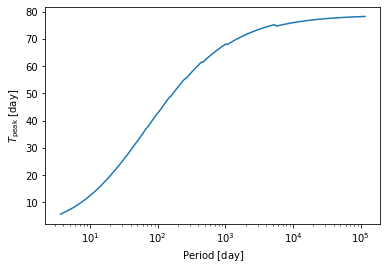

In [33]:
tpeak = []
P = []
Ecc_range = 1 - np.logspace(-1, -4, 200)
for Ecc in Ecc_range:
    tde = TDE(Ecc=Ecc)
    dmdt_Ecc = tde.dmdt
    P = np.append(P, tde.Period)
    tpeak = np.append(tpeak, tde.Tpeak)
plt.plot(P, tpeak)
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\mathrm{Period\ [day]}$')
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$')

In [35]:
q_range = np.logspace(5, 8, 100)
e_cri_1 = 0.9825

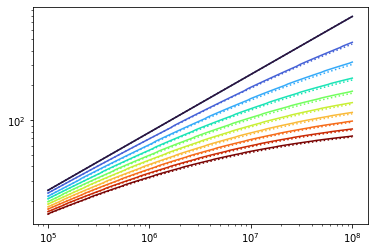

In [72]:
tde0 = [TDE(q=q) for q in q_range]
plt.loglog(q_range, [tde.Tpeak for tde in tde0])

cmap = cm.get_cmap('turbo', 10)

for level, ecc in enumerate(np.linspace(1, e_cri_1, 10)):
    tde_temp = [TDE(q=q, Ecc=ecc) for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
    Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                               ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                         2)
    plt.loglog(q_range,
               tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
               color=cmap(level),
               linestyle=':')

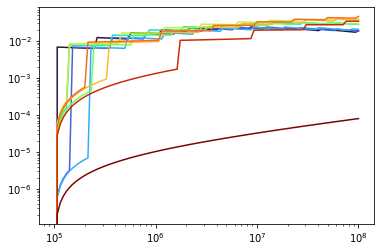

In [73]:
cmap = plt.cm.get_cmap('turbo', 10)
for level, ecc in enumerate(np.linspace(e_cri_1, 1 - 1e-5, 10)):
    tde_temp = [TDE(q=q, Ecc=ecc) for q in q_range]
    #plt.loglog(q_range, [tde.Tpeak for tde in tde_temp])
    Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                               ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                         2)
    plt.loglog(
        q_range,
        abs(tde_temp[0].Tpeak.v * Tpeak_ratio_analyt_temp -
            np.array([tde.Tpeak for tde in tde_temp])) /
        np.array([tde.Tpeak for tde in tde_temp]), color=cmap(level))